In [1]:
## importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix,precision_score, roc_auc_score, recall_score, roc_curve, precision_recall_curve
from time import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
!pip install lime
import lime
import lime.lime_tabular
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.utils import np_utils

     |████████████████████████████████| 276kB 2.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=044d23e2c9402089c69fe6e90610365e06a3bd3072b1245cb968fcf5e839f64f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [2]:
df = pd.read_csv('/content/drive/MyDrive/redshift/classification/sdss.csv')

In [3]:
df.head()

objid          ra        dec  ...  plate    mjd  fiberid
0  1237666301628060000   47.372545   0.820621  ...   7255  56597      832
1  1237673706652430000  116.303083  42.455980  ...   8290  57364      868
2  1237671126974140000  172.756623  -8.785698  ...   2861  54583       42
3  1237665441518260000  201.224207  28.771290  ...   2002  53471       35
4  1237665441522840000  212.817222  26.625225  ...   2123  53793       74

[5 rows x 18 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  int64  
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  uint64 
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17  fiberid    100000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 13.7+

In [5]:
df.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

**Variables description:**

* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)
* u = u-band
* g = g-band
* r = r-band
* i = i-band
* z = z-band
* run = Run Number
* rerun = Rerun Number
* camcol = Camera column
* field = Field number
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)
* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiberID



In [6]:
## checking for null values
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

There are no null elements present in the dataset

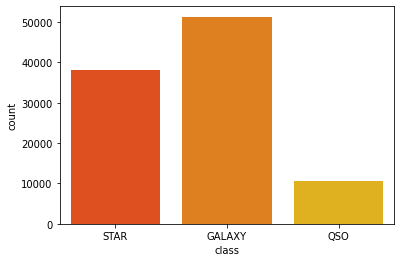

In [7]:
sns.countplot(df['class'], palette = 'autumn')

Target class is imbalanced

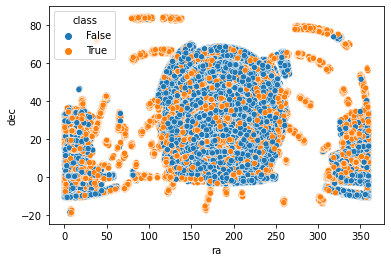

In [8]:
sns.scatterplot(x=df['ra'], y=df["dec"], hue=df["class"]=="STAR")

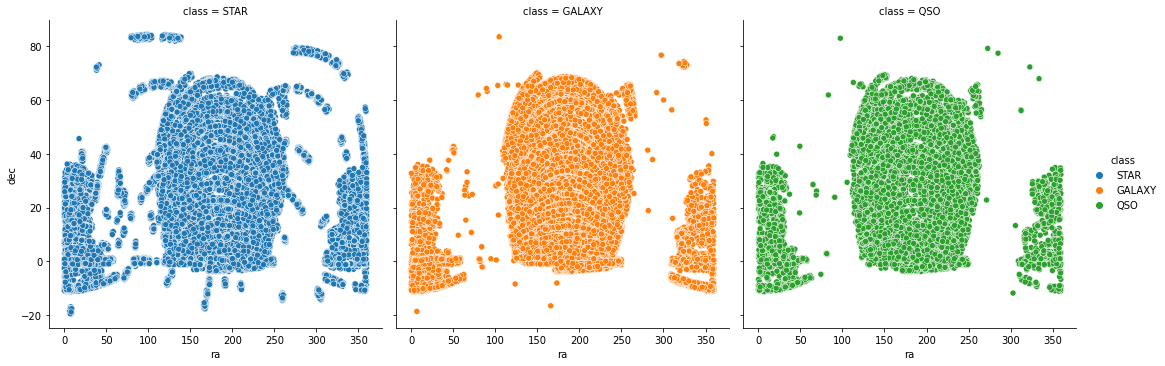

In [9]:
sns.relplot(
    data=df, x="ra", y="dec",
    col="class", 
    kind="scatter",hue = 'class',
)

Features ra and dec seems to be same for all the class, because of this it may not have effect on our target class when modelling.


In [10]:
df.shape

(100000, 18)

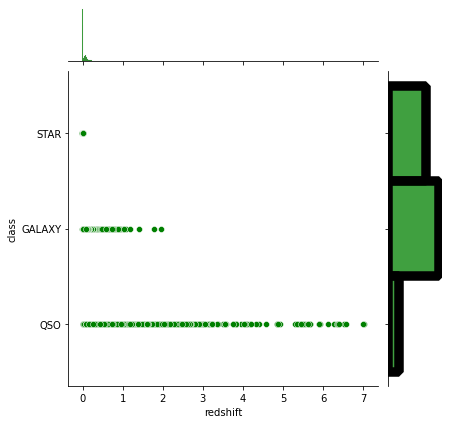

In [11]:
sns.jointplot(x = "redshift", y = "class", data = df,color='green')

From the above plot we can observe that redhift clusters for each target classes are different - stars : 0 - 0.5 , GALAXY - :0 - 2.3 ,QUASORS : 0 -7.

In [12]:
# feat = ['u','i','g','r','z']
# for i, col in enumerate(feat):
#     plt.figure(i)
#     sns.displot(x = df[col],hue = df['class'],kind="kde")


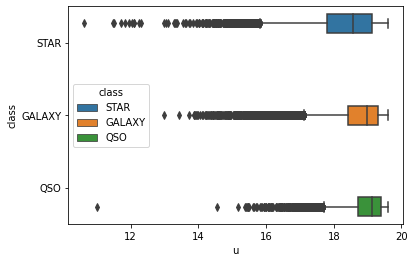

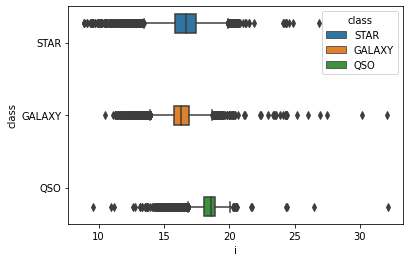

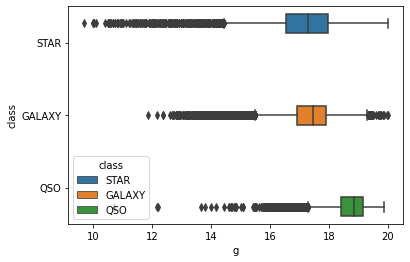

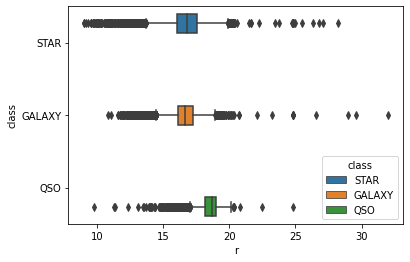

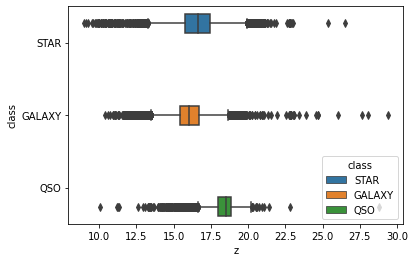

In [13]:
feat = ['u','i','g','r','z']
for i, col in enumerate(feat):
    plt.figure(i)
    sns.boxplot(x = df[col],y = df['class'],hue = df['class'])


From the above box plot , we can observe that U band and g band seems to be more correlated than other bands, i,r,z bands are more correlated to each other than u and g bands.

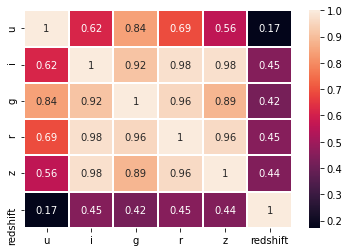

In [14]:
sns.heatmap(df[['u','i','g','r','z','redshift']].corr(),linewidths=1,annot=True)

From the above heatmap, we have considered all the bands and redshift. U band is most uncorrelated band to redshift than others. As seen from the above box plot, we can confirm that the correlation between u and g are higher. Also other bands i,g,z are highly correalted.

In [15]:
df = df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol','field','fiberid'], axis=1)

We will remove ID's and unwanted columns from the dataset.

In [16]:
df.columns

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift', 'plate',
       'mjd'],
      dtype='object')

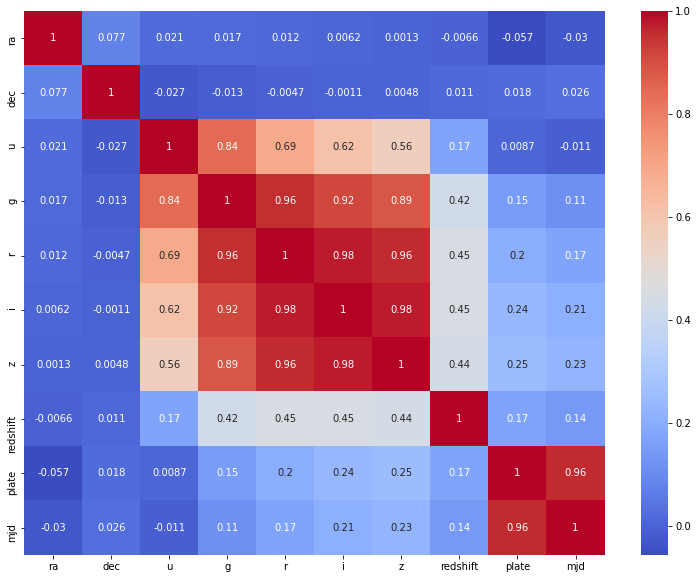

In [17]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

Mjid, plate , ra and dec seems to unwanted for modelingI(as they just id numbers and proven in above plots that they dont change for target class), lets first model with those features and see if it reduces our accuracy.

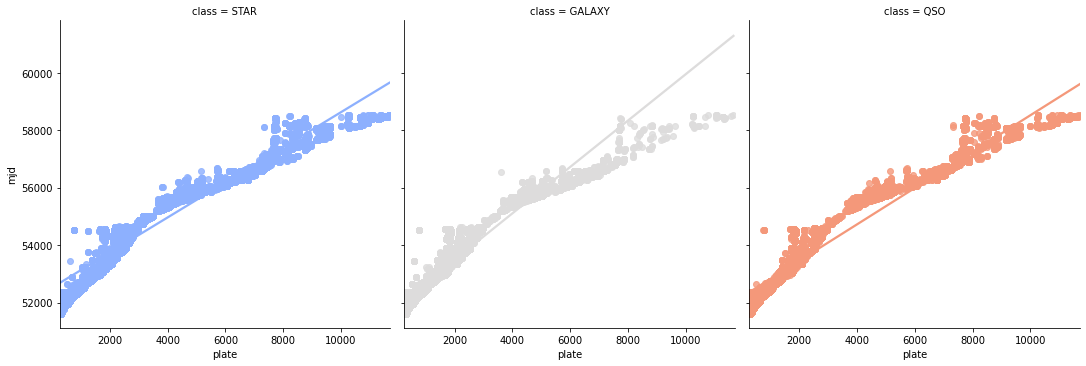

In [18]:
sns.lmplot(x = 'plate', y='mjd', data = df, hue='class', col = 'class', palette='coolwarm')

From the above scattter plot , we can observe that both mjid and plate doesnt change for different classes in our target variable. Also most importantly these two features are the most correlated features , so we might need to delete any one or both if the performance of the model does not improve.

In [19]:
y = df['class']
le = preprocessing.LabelEncoder()
le.fit(y) 
y =le.transform(y)
df = df.drop(['class'], axis=1)

In [20]:
scaler = StandardScaler()

In [21]:
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

In [22]:
df.head()

ra       dec         u  ...  redshift     plate       mjd
0 -1.667639 -1.178162  0.065633  ... -0.389669  2.111259  1.734118
1 -0.784352  0.846200 -0.194147  ... -0.390143  2.579472  2.229841
2 -0.060948 -1.645233 -2.596213  ... -0.389555  0.123507  0.432443
3  0.303841  0.180834 -0.002769  ... -0.257025 -0.265087 -0.286258
4  0.452395  0.076489  0.294775  ... -0.224904 -0.210349 -0.078145

[5 rows x 10 columns]

In [23]:
df.shape

(100000, 10)

In [24]:
len(y)

100000

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.30,random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(70000, 10) (70000,)
(30000, 10) (30000,)


In [56]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
lr_train_acc = lr.score(x_train, y_train)
print('Training Score: ', lr_train_acc)
lr_test_acc = lr.score(x_test, y_test)
print('Testing Score: ', lr_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     15411
           1       0.98      0.94      0.96      3114
           2       0.97      1.00      0.98     11475

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000

Confusion Matrix: 
 [[14994    40   377]
 [  193  2917     4]
 [    3    15 11457]]
Training Score:  0.9788857142857142
Testing Score:  0.9789333333333333


In [60]:
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5]}
grid_clf = GridSearchCV(lr, param_grid = grid_values,cv=5 )
grid_clf.fit(x_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=120, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [61]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)

0.9813142857142857
{'C': 5, 'penalty': 'l2'}


In [63]:
lr = LogisticRegression(C=5,penalty='l2')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
lr_train_acc = lr.score(x_train, y_train)
print('Training Score: ', lr_train_acc)
lr_test_acc = lr.score(x_test, y_test)
print('Testing Score: ', lr_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     15411
           1       0.98      0.94      0.96      3114
           2       0.97      1.00      0.99     11475

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.98     30000
weighted avg       0.98      0.98      0.98     30000

Confusion Matrix: 
 [[15076    41   294]
 [  189  2921     4]
 [    1    13 11461]]
Training Score:  0.9817428571428571
Testing Score:  0.9819333333333333


In [64]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
dt_train_acc = dt.score(x_train, y_train)
dt_test_acc = dt.score(x_test, y_test)
print('Training Score: ', dt_train_acc)
print('Testing Score: ', dt_test_acc)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Training Score:  1.0
Testing Score:  0.9864
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15411
           1       0.94      0.94      0.94      3114
           2       1.00      1.00      1.00     11475

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[15205   186    20]
 [  175  2935     4]
 [   22     1 11452]]


In [66]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rf_train = rf.score(x_train, y_train)
print('Training Score: ', rf_train)
rf_test = rf.score(x_test, y_test)
print('Testing Score: ', rf_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Training Score:  0.9999714285714286
Testing Score:  0.9917333333333334
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15411
           1       0.98      0.94      0.96      3114
           2       1.00      1.00      1.00     11475

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[15346    48    17]
 [  170  2940     4]
 [    9     0 11466]]


In [26]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
rf_train = rf.score(x_train, y_train)
print('Training Score: ', rf_train)
rf_test = rf.score(x_test, y_test)
print('Testing Score: ', rf_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Training Score:  0.9999857142857143
Testing Score:  0.9916333333333334
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15411
           1       0.98      0.94      0.96      3114
           2       1.00      1.00      1.00     11475

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[15349    45    17]
 [  172  2938     4]
 [   13     0 11462]]


In [ ]:
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 10).fit(x_train, y_train)

In [32]:
feature_names = x_train.columns.tolist()
eli5.show_weights(perm, top=None, feature_names=feature_names)

In [34]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values,
                                                   mode = 'classification',
                                                   feature_names = x_train.columns)

In [51]:
predict_fn_rf = lambda x: rf.predict_proba(x).astype(float)
x = x_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(x,feature_names = x_train.columns,class_names=['GALAXY','QUASOR','STAR'],kernel_width=5)
choosen_instance = x_test.values[2]
exp = explainer.explain_instance(choosen_instance,predict_fn_rf,num_features=10,top_labels=2)
exp.show_in_notebook(show_all=False)

In [49]:
choosen_instance = x_test.values[1]
exp = explainer.explain_instance(choosen_instance,predict_fn_rf,num_features=10,top_labels=2)
exp.show_in_notebook(show_all=False)

We can remove Ra and Dec features as it is not affecting the performance of the model.Redshift is the most important feature of all. Also Mjid and PLate features can be removed.